In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from sklearn import preprocessing, metrics
import lightgbm as lgb
import gc
from sklearn.model_selection import TimeSeriesSplit
import random
from tqdm import tqdm, tqdm_notebook
import warnings
from math import sqrt
from joblib import Parallel, delayed
import time

In [2]:
pd.set_option('max_columns',200)
pd.set_option('max_rows',200)

In [3]:
data_path = '../input/m5-forecasting-accuracy'
is_kaggle_env = False

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns毎に処理
        col_type = df[col].dtypes
        if col_type in numerics: #numericsのデータ型の範囲内のときに処理を実行. データの最大最小値を元にデータ型を効率的なものに変更
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
def read_data():
    df_calendar = pd.read_csv(f'{data_path}/calendar.csv')
    if is_kaggle_env:
        df_calendar = reduce_mem_usage(df_calendar)
    df_train = pd.read_csv(f'{data_path}/sales_train_validation.csv')
    if is_kaggle_env:
        df_train = reduce_mem_usage(df_train)
    df_submission = pd.read_csv(f'{data_path}/sample_submission.csv')
    if is_kaggle_env:
        df_submission = reduce_mem_usage(df_submission)
    df_sell_prices = pd.read_csv(f'{data_path}/sell_prices.csv')
    if is_kaggle_env:
        df_sell_prices = reduce_mem_usage(df_sell_prices)
    return df_calendar, df_sell_prices, df_train, df_submission

In [6]:
def encode_categorical(calendar, sales_train_val, sell_prices, cols):
    
    for col in cols:
        lst = []
        if col in calendar.columns:
            lst += calendar[col].unique().tolist()
        if col in sales_train_val.columns:
            lst += sales_train_val[col].unique().tolist()
        if col in sell_prices.columns:
            lst += sell_prices[col].unique().tolist()
            
        lst = list(set(lst))
        le = LabelEncoder()
        le.fit(lst)
        
        if col in calendar.columns:
            calendar[col] = pd.Series(le.transform(calendar[col].fillna('nan').values), index=calendar.index)
        if col in sales_train_val.columns:
            sales_train_val[col] = pd.Series(le.transform(sales_train_val[col].fillna('nan').values), index=sales_train_val.index)
        if col in sell_prices.columns:
            sell_prices[col] = pd.Series(le.transform(sell_prices[col].fillna('nan').values), index=sell_prices.index)
    
#     if type(Encoder) == type(None):
#         Encoder = ce.OrdinalEncoder
#     encoder = ce.BackwardDifferenceEncoder
#     encoder = ce.BaseNEncoder
#     encoder = ce.BinaryEncoder
#     encoder = ce.CatBoostEncoder
#     encoder = ce.HashingEncoder
#     encoder = ce.HelmertEncoder
#     encoder = ce.JamesSteinEncoder
#     encoder = ce.LeaveOneOutEncoder
#     encoder = ce.MEstimateEncoder
#     encoder = ce.OneHotEncoder
#     encoder = ce.OrdinalEncoder
#     encoder = ce.SumEncoder
#     encoder = ce.PolynomialEncoder
#     encoder = ce.TargetEncoder
#     encoder = ce.WOEEncoder

    return calendar, sales_train_val, sell_prices

def prepare_data(sales_train_val, submission, calendar, sell_prices):
    
    NUM_ITEMS = sales_train_val.shape[0]  # 30490
    DAYS_PRED = submission.shape[1] - 1  # 28
    nrows = 365 * 2 * NUM_ITEMS

    # sales_train_valからidの詳細部分(itemやdepartmentなどのid)を重複なく一意に取得しておく。(extract a detail of id columns)
    product = sales_train_val[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    d_name = [f'd_{i+1}' for i in range(1913)]
    sales_train_val_values = sales_train_val[d_name].values

    # calculate the start position(first non-zero demand observed date) for each item / 商品の最初の売上日
    # 1-1914のdayの数列のうち, 売上が存在しない日を一旦0にし、0を9999に置換。そのうえでminimum numberを計算
    tmp = np.tile(np.arange(1,1914),(sales_train_val_values.shape[0],1))
    df_tmp = ((sales_train_val_values>0) * tmp)
    start_no = np.min(np.where(df_tmp==0,9999,df_tmp),axis=1)-1

    flag = np.dot(np.diag(1/(start_no+1)) , tmp)<1
    sales_train_val_values = np.where(flag,np.nan,sales_train_val_values)
    sales_train_val[d_name] = sales_train_val_values
    sales_train_val = pd.melt(sales_train_val, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')

    sales_train_val = sales_train_val.iloc[-nrows:,:]
    sales_train_val = sales_train_val[~sales_train_val.demand.isnull()]

    # submission fileのidのvalidation部分と, ealuation部分の名前を取得
    test1_rows = [row for row in submission['id'] if 'validation' in row]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]

    # submission fileのvalidation部分をtest1, ealuation部分をtest2として取得
    test1 = submission[submission['id'].isin(test1_rows)]
    test2 = submission[submission['id'].isin(test2_rows)]

    # test1, test2の列名の"F_X"の箇所をd_XXX"の形式に変更
    test1.columns = ["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)]
    test2.columns = ["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)]

    # test2のidの'_evaluation'を置換
    #test1['id'] = test1['id'].str.replace('_validation','')
    test2['id'] = test2['id'].str.replace('_evaluation','_validation')

    # idをキーにして, idの詳細部分をtest1, test2に結合する.
    test1 = test1.merge(product, how = 'left', on = 'id')
    test2 = test2.merge(product, how = 'left', on = 'id')

    # test1, test2をともにmelt処理する.（売上数量:demandは0）
    test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],  var_name = 'day', value_name = 'demand')
    test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],  var_name = 'day', value_name = 'demand')

    # validation部分と, evaluation部分がわかるようにpartという列を作り、 test1,test2のラベルを付ける。
    sales_train_val['part'] = 'train'
    test1['part'] = 'test1'
    test2['part'] = 'test2'

    # sales_train_valとtest1, test2の縦結合.
    data = pd.concat([sales_train_val, test1, test2], axis = 0)

    # delete test2 for now(6/1以前は, validation部分のみ提出のため.)
    data = data[data['part'] != 'test2']

    #calendarの結合
    # drop some calendar features(不要な変数の削除:weekdayやwdayなどはdatetime変数から後ほど作成できる。)
    calendar.drop(['weekday', 'wday', 'month', 'year'],   inplace = True, axis = 1)
    # notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)(dayとdをキーにdataに結合)
    data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
    data.drop(['d', 'day'], inplace = True, axis = 1)

    #sell priceの結合
    # get the sell price data (this feature should be very important)
    data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
    
    return data, product

def simple_fe(data):
    
    # demand features(過去の数量から変数生成)
    
    for diff in [0, 1, 2]:
        shift = DAYS_PRED + diff
        data[f"shift_t{shift}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(shift))
    '''
    for size in [7, 30, 60, 90, 180]:
        data[f"rolling_std_t{size}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(DAYS_PRED).rolling(size).std())
    '''
    for size in [7, 30, 60, 90, 180]:
        data[f"rolling_mean_t{size}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(DAYS_PRED).rolling(size).mean())
        
#     for size in [7, 30, 60, 90, 180]:
#         data[f"rolling_std_t{size}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(DAYS_PRED).rolling(size).std())
        
    '''
    data["rolling_skew_t30"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(DAYS_PRED).rolling(30).skew())
    data["rolling_kurt_t30"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(DAYS_PRED).rolling(30).kurt())
    '''
    # price features
    # priceの動きと特徴量化（価格の変化率、過去1年間の最大価格との比など）
    
    data["shift_price_t1"] = data.groupby(["id"])["sell_price"].transform(lambda x: x.shift(1))
    data["price_change_t1"] = (data["shift_price_t1"] - data["sell_price"]) / (data["shift_price_t1"])
    data["rolling_price_max_t365"] = data.groupby(["id"])["sell_price"].transform(lambda x: x.shift(1).rolling(365).max())
    data["price_change_t365"] = (data["rolling_price_max_t365"] - data["sell_price"]) / (data["rolling_price_max_t365"])
    data["rolling_price_std_t7"] = data.groupby(["id"])["sell_price"].transform(lambda x: x.rolling(7).std())
    data["rolling_price_std_t30"] = data.groupby(["id"])["sell_price"].transform(lambda x: x.rolling(30).std())
    
    # time features
    # 日付に関するデータ
    dt_col = "date"
    data[dt_col] = pd.to_datetime(data[dt_col])
    
    attrs = [
        "year",
        "quarter",
        "month",
        "week",
        "day",
        "dayofweek",
        "is_year_end",
        "is_year_start",
        "is_quarter_end",
        "is_quarter_start",
        "is_month_end",
        "is_month_start",
    ]

    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        data[attr] = getattr(data[dt_col].dt, attr).astype(dtype)

    data["is_weekend"] = data["dayofweek"].isin([5, 6]).astype(np.int8)
    
    return data

def get_weight_mat_csr():
    
    weight_mat = np.c_[np.ones([NUM_ITEMS,1]).astype(np.int8), # level 1
                   pd.get_dummies(product.state_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.store_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.cat_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.dept_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.state_id.astype(str) + product.cat_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.state_id.astype(str) + product.dept_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.store_id.astype(str) + product.cat_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.store_id.astype(str) + product.dept_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.item_id.astype(str),drop_first=False).astype('int8').values,
                   pd.get_dummies(product.state_id.astype(str) + product.item_id.astype(str),drop_first=False).astype('int8').values,
                   np.identity(NUM_ITEMS).astype(np.int8) #item :level 12
                   ].T

    weight_mat_csr = csr_matrix(weight_mat)
    return weight_mat_csr
    

def weight_calc(data,product):
    

    
    # calculate the denominator of RMSSE, and calculate the weight base on sales amount

    sales_train_val = pd.read_csv(f'{data_path}/sales_train_validation.csv')

    d_name = ['d_' + str(i+1) for i in range(1913)]

    sales_train_val = weight_mat_csr * sales_train_val[d_name].values

    # calculate the start position(first non-zero demand observed date) for each item / 商品の最初の売上日
    # 1-1914のdayの数列のうち, 売上が存在しない日を一旦0にし、0を9999に置換。そのうえでminimum numberを計算
    df_tmp = ((sales_train_val>0) * np.tile(np.arange(1,1914),(weight_mat_csr.shape[0],1)))

    start_no = np.min(np.where(df_tmp==0,9999,df_tmp),axis=1)-1

    flag = np.dot(np.diag(1/(start_no+1)) , np.tile(np.arange(1,1914),(weight_mat_csr.shape[0],1)))<1

    sales_train_val = np.where(flag,np.nan,sales_train_val)

    # denominator of RMSSE / RMSSEの分母
    weight1 = np.nansum(np.diff(sales_train_val,axis=1)**2,axis=1)/(1913-start_no)

    # calculate the sales amount for each item/level
    df_tmp = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    df_tmp['amount'] = df_tmp['demand'] * df_tmp['sell_price']
    df_tmp =df_tmp.groupby(['id'])['amount'].apply(np.sum)
    df_tmp = df_tmp[product.id].values
    
    weight2 = weight_mat_csr * df_tmp 

    weight2 = weight2/np.sum(weight2)

    del sales_train_val
    gc.collect()
    
    return weight1, weight2

def wrmsse(preds, data):
    
    # this function is calculate for last 28 days to consider the non-zero demand period
    
    # actual obserbed values / 正解ラベル
    y_true = data.get_label()
    
    y_true = y_true[-(NUM_ITEMS * DAYS_PRED):]
    preds = preds[-(NUM_ITEMS * DAYS_PRED):]
    # number of columns
    num_col = DAYS_PRED
    
    # reshape data to original array((NUM_ITEMS*num_col,1)->(NUM_ITEMS, num_col) ) / 推論の結果が 1 次元の配列になっているので直す
    reshaped_preds = preds.reshape(num_col, NUM_ITEMS).T
    reshaped_true = y_true.reshape(num_col, NUM_ITEMS).T
    
          
    train = weight_mat_csr*np.c_[reshaped_preds, reshaped_true]
    
    score = np.sum(
                np.sqrt(
                    np.mean(
                        np.square(
                            train[:,:num_col] - train[:,num_col:])
                        ,axis=1) / weight1) * weight2)
    
    return 'wrmsse', score, False

def wrmsse_simple(preds, data):
    
    # actual obserbed values / 正解ラベル
    y_true = data.get_label()
    
    y_true = y_true[-(NUM_ITEMS * DAYS_PRED):]
    preds = preds[-(NUM_ITEMS * DAYS_PRED):]
    # number of columns
    num_col = DAYS_PRED
    
    # reshape data to original array((NUM_ITEMS*num_col,1)->(NUM_ITEMS, num_col) ) / 推論の結果が 1 次元の配列になっているので直す
    reshaped_preds = preds.reshape(num_col, NUM_ITEMS).T
    reshaped_true = y_true.reshape(num_col, NUM_ITEMS).T
          
    train = np.c_[reshaped_preds, reshaped_true]
    
    weight2_2 = weight2[:NUM_ITEMS]
    weight2_2 = weight2_2/np.sum(weight2_2)
    
    score = np.sum(
                np.sqrt(
                    np.mean(
                        np.square(
                            train[:,:num_col] - train[:,num_col:])
                        ,axis=1) /  weight1[:NUM_ITEMS])*weight2_2)
    
    return 'wrmsse', score, False

In [105]:
calendar, sell_prices, sales_train_val, submission = read_data()

In [8]:
NUM_ITEMS = sales_train_val.shape[0]  # 30490
DAYS_PRED = submission.shape[1] - 1  # 28

In [106]:
calendar['d'] = calendar['d'].apply(lambda x : int(x[2:]))

d2wm_yr_wk = dict(zip(calendar.d,calendar.wm_yr_wk))
groupby_ = calendar.groupby('wm_yr_wk')
wm_yr_wk2fd = dict(zip(groupby_.groups.keys(), groupby_['d'].apply(lambda x: min(x))))
wm_yr_wk2ld = dict(zip(groupby_.groups.keys(), groupby_['d'].apply(lambda x: max(x))))

for col in ['event_name_1', 'event_type_1','event_name_2','event_type_2']:
    calendar = pd.concat([calendar, pd.get_dummies(calendar[col],  prefix=''.join([t[0] for t in col.split('_')]))],axis=1)
    calendar.drop([col], axis=1, inplace=True)
calendar.set_index(['d'], inplace=True)
calendar.drop(columns=['weekday'], inplace=True)
calendar.columns = [col.replace(' ', '_') for col in calendar.columns]

In [95]:
calendar.describe()

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,en1_Chanukah End,en1_Christmas,en1_Cinco De Mayo,en1_ColumbusDay,en1_Easter,en1_Eid al-Fitr,en1_EidAlAdha,en1_Father's day,en1_Halloween,en1_IndependenceDay,en1_LaborDay,en1_LentStart,en1_LentWeek2,en1_MartinLutherKingDay,en1_MemorialDay,en1_Mother's day,en1_NBAFinalsEnd,en1_NBAFinalsStart,en1_NewYear,en1_OrthodoxChristmas,en1_OrthodoxEaster,en1_Pesach End,en1_PresidentsDay,en1_Purim End,en1_Ramadan starts,en1_StPatricksDay,en1_SuperBowl,en1_Thanksgiving,en1_ValentinesDay,en1_VeteransDay,et1_Cultural,et1_National,et1_Religious,et1_Sporting,en2_Cinco De Mayo,en2_Easter,en2_Father's day,en2_OrthodoxEaster,et2_Cultural,et2_Religious
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002031,0.002539,0.002539,0.002539,0.003047,0.003047,0.002539,0.003047,0.003047,0.003047,0.003047,0.002539,0.002539,0.002539,0.003047,0.003047,0.003047,0.003047,0.003047,0.003047,0.002539,0.003047,0.002539,0.018791,0.026409,0.027933,0.009142,0.000508,0.000508,0.001016,0.000508,0.002031,0.000508
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374,0.050341,0.050341,0.050341,0.050341,0.050341,0.050341,0.050341,0.045038,0.050341,0.050341,0.050341,0.055132,0.055132,0.050341,0.055132,0.055132,0.055132,0.055132,0.050341,0.050341,0.050341,0.055132,0.055132,0.055132,0.055132,0.055132,0.055132,0.050341,0.055132,0.050341,0.135822,0.160390,0.164823,0.095198,0.022536,0.022536,0.031863,0.022536,0.045038,0.022536
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00

In [108]:
calendar_w = calendar.drop(columns=['date','wday','month','year']).groupby(['wm_yr_wk']).apply(lambda x: np.sum(x))
calendar_w['wm_yr_wk'] = calendar_w.index.tolist()
calendar_w.reset_index(drop=True, inplace=True)

In [109]:
calendar_w

,wm_yr_wk,snap_CA,snap_TX,snap_WI,en1_Chanukah_End,en1_Christmas,en1_Cinco_De_Mayo,en1_ColumbusDay,en1_Easter,en1_Eid_al-Fitr,en1_EidAlAdha,en1_Father's_day,en1_Halloween,en1_IndependenceDay,en1_LaborDay,en1_LentStart,en1_LentWeek2,en1_MartinLutherKingDay,en1_MemorialDay,en1_Mother's_day,en1_NBAFinalsEnd,en1_NBAFinalsStart,en1_NewYear,en1_OrthodoxChristmas,en1_OrthodoxEaster,en1_Pesach_End,en1_PresidentsDay,en1_Purim_End,en1_Ramadan_starts,en1_StPatricksDay,en1_SuperBowl,en1_Thanksgiving,en1_ValentinesDay,en1_VeteransDay,et1_Cultural,et1_National,et1_Religious,et1_Sporting,en2_Cinco_De_Mayo,en2_Easter,en2_Father's_day,en2_OrthodoxEaster,et2_Cultural,et2_Religious
0,11101,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,11102,6,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,11103,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
3,11104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,11105,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,11617,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
278,11618,3,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
279,11619,7,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
280,11620,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [110]:
sell_prices['id'] = sell_prices[['item_id', 'store_id']].apply(lambda x: f'{x[0]}_{x[1]}_validation', axis=1)
sell_prices.drop(columns=['store_id', 'item_id'], inplace=True)
sell_prices.set_index(['id'], inplace=True)

In [111]:
sell_prices

,wm_yr_wk,sell_price
id,,
HOBBIES_1_001_CA_1_validation,11325,9.58
HOBBIES_1_001_CA_1_validation,11326,9.58
HOBBIES_1_001_CA_1_validation,11327,8.26
HOBBIES_1_001_CA_1_validation,11328,8.26
HOBBIES_1_001_CA_1_validation,11329,8.26
...,...,...
FOODS_3_827_WI_3_validation,11617,1.00
FOODS_3_827_WI_3_validation,11618,1.00
FOODS_3_827_WI_3_validation,11619,1.00


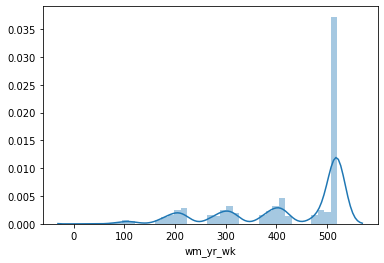

In [63]:
sns.distplot(sell_prices.groupby(sell_prices.index)['wm_yr_wk'].apply(lambda x : max(x)-min(x)))

In [112]:
sales_train_val.rename(columns=dict(zip([f'd_{i}' for i in range(1, 1914)], np.arange(1,1914))), inplace=True)

In [113]:
sales_train_val['store_id'] = sales_train_val['store_id'].apply(lambda x: int(x.split('_')[-1]))
sales_train_val['dept_id'] = sales_train_val['dept_id'].apply(lambda x: int(x.split('_')[-1]))
sales_train_val['item_id'] = sales_train_val['item_id'].apply(lambda x: int(x.split('_')[-1]))
sales_train_val.set_index('id', inplace=True)

In [114]:
sales_train_val.loc[HOBBIES_1_001_CA_1_validation]

,item_id,dept_id,cat_id,store_id,state_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,...,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,1,1,HOBBIES,1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,2,1,0,0,0,1,1,1,0,0,1,1,1,1,1,0,0,0,2,2,0,0,1,4,0,0,0,0,1,1,2,0,4,0,1,0,1,4,2,0,2,0,1,1,0,1,0,0,1,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002_CA_1_validation,2,1,HOBBIES,1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003_CA_1_validation,3,1,HOBBIES,1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,1,1,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
HOBBIES_1_004_CA_1_validation,4,1,HOBBIES,1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,0,0,0,0,0,2,0,1,0,0,1,1,1,0,2,3,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,2,3,0,2,0,0,2,2,0,0,2,1,2,1,1,1,2,0,...,3,2,4,3,1,2,3,0,8,2,1,2,2,5,2,6,1,0,3,5,1,1,6,4,3,2,2,3,2,1,0,0,0,2,0,5,4,2,1,1,2,3,0,6,0,0,0,1,0,1,5,3,1,0,0,0,1,2,3,0,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
HOBBIES_1_005_CA_1_validation,5,1,HOBBIES,1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,3,0,0,1,1,0,3,1,0,4,1,2,0,0,0,1,1,2,0,0,5,2,2,2,1,0,0,0,3,0,0,0,3,1,1,1,1,2,1,0,0,1,0,2,1,1,0,3,1,1,2,1,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [117]:
def quantile99(x):
    return np.quantile(x, 0.99)

def quantile95(x):
    return np.quantile(x, 0.95)

def quantile75(x):
    return np.quantile(x, 0.75)

def quantile25(x):
    return np.quantile(x, 0.25)

def quantile05(x):
    return np.quantile(x, 0.05)

def quantile01(x):
    return np.quantile(x, 0.01)

def rolling7mean(x):
    return pd.Series(x).rolling(7).mean()

def rolling7std(x):
    return pd.Series(x).rolling(7).std()

def rolling30mean(x):
    return pd.Series(x).rolling(30).mean()

def rolling30std(x):
    return pd.Series(x).rolling(30).std()

def lag1(x):
    return x[-1]

def lag2(x):
    return x[-2]

def lag3(x):
    return x[-3]

def lag4(x):
    return x[-4]
    
agg_functions1 = [np.min, np.max, np.mean, np.std]
agg_functions2 = [quantile99, quantile95, quantile75, quantile25, quantile05, quantile01]
agg_functions3 = [rolling7mean, rolling7std, rolling30mean, rolling30std]
agg_functions4 = [lag1, lag2, lag3, lag4]


for f in agg_functions1+agg_functions2+agg_functions3+agg_functions4:
    print(f.__name__)

amin
amax
mean
std
quantile99
quantile95
quantile75
quantile25
quantile05
quantile01
rolling7mean
rolling7std
rolling30mean
rolling30std
lag1
lag2
lag3
lag4


In [158]:
def _add_feature(feature_d, name, function, data, useless_feature_names):
#         if (type(useless_feature_names) != type(None)) and (name in useless_feature_names):
#             pass
#         else:
    try:
        feature_d[name] = function(data)
    except:
        feature_d[name] = np.NaN
    
def _extract_features_i(start_y_d, id_, calendar, sub_sell_prices, sub_sales_train_val, useless_feature_names=None, is_test=False):
    
    y_days = np.arange(start_y_d, start_y_d+28)
    last_wm_yr_wk = d2wm_yr_wk[y_days[-1]]
    start_wm_yr_wk = sub_sell_prices['wm_yr_wk'].min()
    start_d = wm_yr_wk2fd[start_wm_yr_wk]
    end_d = y_days[0]-1

    feature_d = {}
    ## category feature
    feature_d['id'] = id_
    feature_d['item_id'] = sub_sales_train_val['item_id']
    feature_d['dept_id'] = sub_sales_train_val['dept_id']
    feature_d['cat_id'] = sub_sales_train_val['cat_id']
    feature_d['store_id'] = sub_sales_train_val['store_id']
    feature_d['state_id'] = sub_sales_train_val['state_id']
    
    
    ## price feature
    dat_ = sub_sell_prices['sell_price']
    for f in agg_functions4:
        _add_feature(feature_d, f'prices_{f.__name__}', f, dat_, useless_feature_names)
    for f in agg_functions1:
        _add_feature(feature_d, f'price_{f.__name__}', f, dat_, useless_feature_names)
        
    dat_ = dat_[-24:]
    for f in agg_functions1:
        _add_feature(feature_d, f'latest_halfyear_price_{f.__name__}', f, dat_, useless_feature_names)
        
    dat_ = dat_[-4:]
    for f in agg_functions1:
        _add_feature(feature_d, f'latest_month_price_{f.__name__}', f, dat_, useless_feature_names)

    ## sales feature
    dat_ = sub_sales_train_val.loc[np.arange(start_d, end_d+1)].values
    for f in agg_functions4:
        _add_feature(feature_d, f'sales_{f.__name__}', f, dat_, useless_feature_names)
    for f in agg_functions1+agg_functions2+agg_functions3:
        _add_feature(feature_d, f'sales_{f.__name__}', f, dat_.astype(float), useless_feature_names)
    dat_ = dat_[-180:]
    for f in agg_functions1+agg_functions2+agg_functions3:
        _add_feature(feature_d, f'latest_halfyear_sales_{f.__name__}', f, dat_.astype(float), useless_feature_names)
    dat_ = dat_[-30:]
    for f in agg_functions1+agg_functions2+agg_functions3:
        _add_feature(feature_d, f'latest_month_sales_{f.__name__}', f, dat_.astype(float), useless_feature_names)

    if is_test:
        y_d = dict(zip([f'F{i}' for i in range(1,29)], [0]*28))
    else :
        y_d = dict(zip([f'F{i}' for i in range(1,29)], sub_sales_train_val[y_days]))
    
    return {**feature_d, **y_d}

In [164]:
def _extract_features_objective(item, calendar, sales_train_val, sell_prices, n_samples):
    
    id_ = item
    train_y_start_d_list =[1858]
    train_y_start_d_list += [random.randrange(int(1858*.75), 1886-28) for _ in range(n_samples-1)]
    valid_y_start_d_list = [1886]
    test_y_start_d_list = [1914]
    
    lst_ = []
    try:
        sub_sales_train_val = sales_train_val.loc[id_]
        sub_sell_prices = sell_prices.loc[id_]

        for start_d in train_y_start_d_list:
            d_ = _extract_features_i(start_d, id_, calendar, sub_sell_prices, sub_sales_train_val)
            lst_.append({'type':'train',**d_})

        for start_d in valid_y_start_d_list:
            d_ = _extract_features_i(start_d, id_, calendar, sub_sell_prices, sub_sales_train_val)
            lst_.append({'type':'valid',**d_})

        for start_d in test_y_start_d_list:
            d_ = _extract_features_i(start_d, id_, calendar, sub_sell_prices, sub_sales_train_val, is_test=True)
            lst_.append({'type':'test',**d_})
        
    except Exception as e:
        raise Exception(item, e.__str__())
    return lst_

def extract_features(calendar, sell_prices, sales_train_val, n_samples, n_jobs=-1, verbose=1):

    list_=[]
    Index_ = sales_train_val.index
    worker_parameter = (calendar,sales_train_val,sell_prices,n_samples)
    sub_list = Parallel(n_jobs=n_jobs)(delayed(_extract_features_objective)(idx_, *worker_parameter) for idx_ in tqdm_notebook(Index_))
    list_ += sum(sub_list, []) 
    return pd.DataFrame(list_)

# sell_prices['sell_prices']
# sell_prices.loc[id_]

In [ ]:
df_feats = extract_features(calendar, sell_prices, sales_train_val, n_samples=2, n_jobs=8)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [237]:
df_ = sell_prices.loc[id_]
df_ = df_[df_['wm_yr_wk']<=last_wm_yr_wk]
print()

11325


In [282]:
sales_train_val.loc[id_][[f'd_{i}' for i in range(int(start_d[2:]), int(end_d[2:])+1)]].values

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 2, 3, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 2, 1, 0, 0, 1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 3, 0,
       0, 3, 0, 1, 1, 2, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0,
       0, 0, 2, 1, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [175]:
id_ in sales_train_val.index

False

In [176]:
sales_train_val

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,...,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,2,1,0,0,0,1,1,1,0,0,1,1,1,1,1,0,0,0,2,2,0,0,1,4,0,0,0,0,1,1,2,0,4,0,1,0,1,4,2,0,2,0,1,1,0,1,0,0,1,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,1,1,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,0,0,0,0,0,2,0,1,0,0,1,1,1,0,2,3,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,2,3,0,2,0,0,2,2,0,0,2,1,2,1,1,1,2,...,3,2,4,3,1,2,3,0,8,2,1,2,2,5,2,6,1,0,3,5,1,1,6,4,3,2,2,3,2,1,0,0,0,2,0,5,4,2,1,1,2,3,0,6,0,0,0,1,0,1,5,3,1,0,0,0,1,2,3,0,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,3,0,0,1,1,0,3,1,0,4,1,2,0,0,0,1,1,2,0,0,5,2,2,2,1,0,0,0,3,0,0,0,3,1,1,1,1,2,1,0,0,1,0,2,1,1,0,3,1,1,2,1,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [142]:
sales_groupby_id = sales_train_val.groupby(['id','item_id','dept_id','cat_id','store_id','state_id'])

In [147]:
for (price_condition, price_group), (sales_condition, sales_group) in zip(price_groupby_id, sales_groupby_id):
    break

In [153]:
sales_group.iloc

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,...,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
1612,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,0,1,4,2,0,2,0,0,0,0,3,1,3,0,2,1,2,0,2,1,2,0,2,2,2,4,2,2,0,2,1,7,1,2,3,0,1,2,3,0,1,5,0,0,1,0,0,1,1,1,1,1,0,1,2,2,0,1,0,0,0,0,0,4,0,1,0,1,0,2,2,1,1,0,2,1,2,0,2,0,0,0,1,0,0,0,0,0,0,3,2,7,...,0,1,0,0,0,1,0,0,0,0,1,1,2,1,0,2,0,2,0,3,1,2,0,2,0,0,2,0,0,2,1,0,1,0,1,2,0,0,1,0,0,0,0,0,1,0,1,0,0,2,0,0,0,0,1,1,1,1,3,0,0,2,1,2,2,0,2,2,0,1,1,0,2,1,1,0,4,0,0,4,1,3,0,1,0,2,2,0,1,1,0,2,0,4,1,1,0,1,1,0


In [ ]:
Y_train = 

In [152]:
Y = 

,store_id,item_id,wm_yr_wk,sell_price,id,snap_CA,snap_TX,snap_WI,en1_Chanukah End,en1_Christmas,en1_Cinco De Mayo,en1_ColumbusDay,en1_Easter,en1_Eid al-Fitr,en1_EidAlAdha,en1_Father's day,en1_Halloween,en1_IndependenceDay,en1_LaborDay,en1_LentStart,en1_LentWeek2,en1_MartinLutherKingDay,en1_MemorialDay,en1_Mother's day,en1_NBAFinalsEnd,en1_NBAFinalsStart,en1_NewYear,en1_OrthodoxChristmas,en1_OrthodoxEaster,en1_Pesach End,en1_PresidentsDay,en1_Purim End,en1_Ramadan starts,en1_StPatricksDay,en1_SuperBowl,en1_Thanksgiving,en1_ValentinesDay,en1_VeteransDay,et1_Cultural,et1_National,et1_Religious,et1_Sporting,en2_Cinco De Mayo,en2_Easter,en2_Father's day,en2_OrthodoxEaster,et2_Cultural,et2_Religious
368746,CA_1,FOODS_1_001,11101,2.00,FOODS_1_001_CA_1_validation,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
368747,CA_1,FOODS_1_001,11102,2.00,FOODS_1_001_CA_1_validation,6,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
368748,CA_1,FOODS_1_001,11103,2.00,FOODS_1_001_CA_1_validation,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
368749,CA_1,FOODS_1_001,11104,2.00,FOODS_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
368750,CA_1,FOODS_1_001,11105,2.00,FOODS_1_001_CA_1_validation,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369023,CA_1,FOODS_1_001,11617,2.24,FOODS_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
369024,CA_1,FOODS_1_001,11618,2.24,FOODS_1_001_CA_1_validation,3,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
369025,CA_1,FOODS_1_001,11619,2.24,FOODS_1_001_CA_1_validation,7,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
369026,CA_1,FOODS_1_001,11620,2.24,FOODS_1_001_CA_1_validation,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [150]:
price_group

,store_id,item_id,wm_yr_wk,sell_price,id,snap_CA,snap_TX,snap_WI,en1_Chanukah End,en1_Christmas,en1_Cinco De Mayo,en1_ColumbusDay,en1_Easter,en1_Eid al-Fitr,en1_EidAlAdha,en1_Father's day,en1_Halloween,en1_IndependenceDay,en1_LaborDay,en1_LentStart,en1_LentWeek2,en1_MartinLutherKingDay,en1_MemorialDay,en1_Mother's day,en1_NBAFinalsEnd,en1_NBAFinalsStart,en1_NewYear,en1_OrthodoxChristmas,en1_OrthodoxEaster,en1_Pesach End,en1_PresidentsDay,en1_Purim End,en1_Ramadan starts,en1_StPatricksDay,en1_SuperBowl,en1_Thanksgiving,en1_ValentinesDay,en1_VeteransDay,et1_Cultural,et1_National,et1_Religious,et1_Sporting,en2_Cinco De Mayo,en2_Easter,en2_Father's day,en2_OrthodoxEaster,et2_Cultural,et2_Religious
368746,CA_1,FOODS_1_001,11101,2.00,FOODS_1_001_CA_1_validation,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
368747,CA_1,FOODS_1_001,11102,2.00,FOODS_1_001_CA_1_validation,6,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
368748,CA_1,FOODS_1_001,11103,2.00,FOODS_1_001_CA_1_validation,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
368749,CA_1,FOODS_1_001,11104,2.00,FOODS_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
368750,CA_1,FOODS_1_001,11105,2.00,FOODS_1_001_CA_1_validation,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369023,CA_1,FOODS_1_001,11617,2.24,FOODS_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
369024,CA_1,FOODS_1_001,11618,2.24,FOODS_1_001_CA_1_validation,3,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
369025,CA_1,FOODS_1_001,11619,2.24,FOODS_1_001_CA_1_validation,7,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
369026,CA_1,FOODS_1_001,11620,2.24,FOODS_1_001_CA_1_validation,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def extract_features(n_samples=1):
    
    
    for condition, group in zip(groupby,:
        

In [ ]:
sales_train_val[[f'd_']]

In [19]:
sales_train_val['type']=sales_train_val.id.apply(lambda x : x.split('_')[-1])

In [21]:
sales_train_val['type'].value_counts()

validation    30490
Name: type, dtype: int64

In [73]:
calendar, sales_train_val, sell_prices = encode_categorical(calendar, sales_train_val, sell_prices,  ["event_name_1", "event_type_1", "event_name_2", "event_type_2", "item_id", "dept_id", "cat_id", "store_id", "state_id"])

In [74]:
df_data, product = prepare_data(sales_train_val, submission, calendar, sell_prices)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [77]:
for condition, group in df_data.groupby(by=['id']):
    

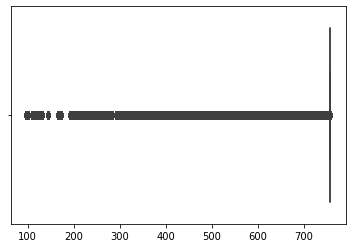

In [167]:
count = df_data.groupby(by=['id']).transform(lambda x: x.shape[0])
sns.boxplot(count)

In [164]:
group[['demand', 'date']][:100]

,demand,date
1496,0.0,2014-04-26
29189,0.0,2014-04-27
56895,1.0,2014-04-28
84606,1.0,2014-04-29
112332,1.0,2014-04-30
140069,1.0,2014-05-01
167818,3.0,2014-05-02
195578,1.0,2014-05-03
223353,1.0,2014-05-04
251147,0.0,2014-05-05


In [ ]:
g_ = df_data.groupby(["id"])
tmp_ = g_["demand"].transform(lambda x: x.shift(28)).values
tmp2_ = g_["date"].transform(lambda x: x.shift(28)).values
tmp3_ = g_.transform(lambda x: x).values

In [ ]:
for idx, (v, d, d2) in enumerate(zip(tmp_[7::NUM_ITEMS], tmp2_[7::NUM_ITEMS], tmp3_[7::NUM_ITEMS, 7])):
    print(idx, v, d, d2)
    if idx > 100:
        break

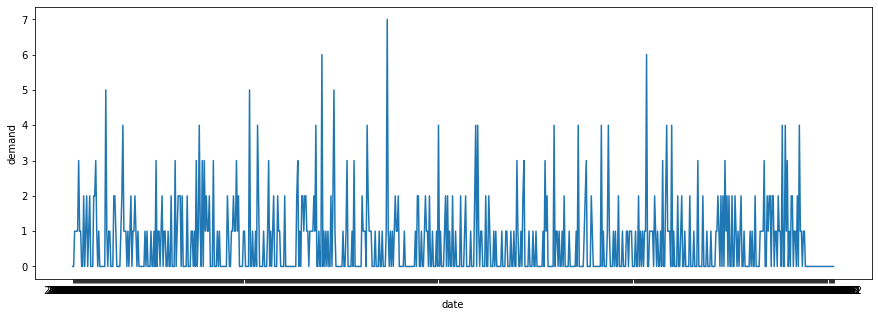

In [84]:
plt.figure(figsize=(15,5))
sns.lineplot(x='date', y='demand', data=group)

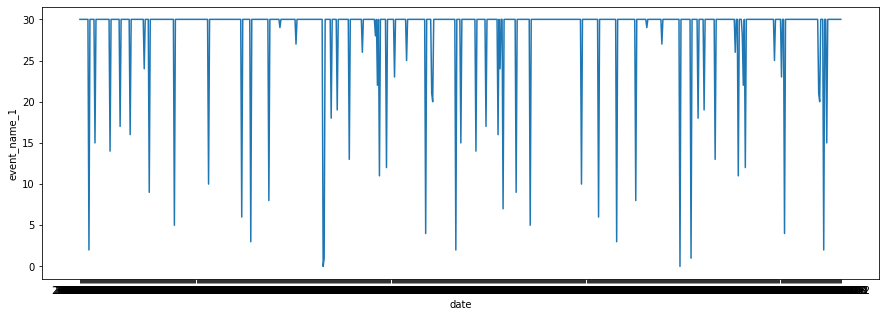

In [85]:
plt.figure(figsize=(15,5))
sns.lineplot(x='date', y='event_name_1', data=group)

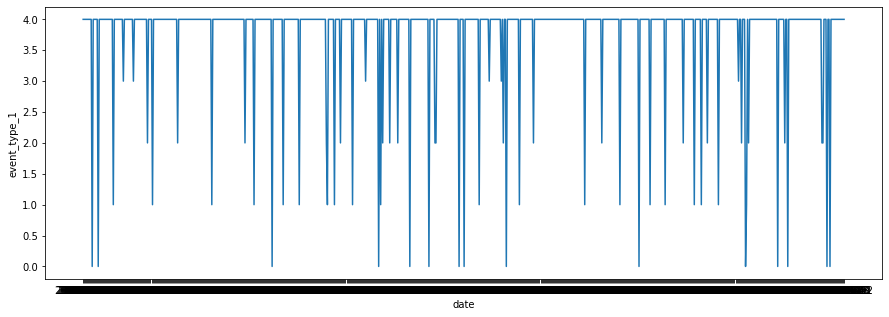

In [87]:
plt.figure(figsize=(15,5))
sns.lineplot(x='date', y='event_type_1', data=group)

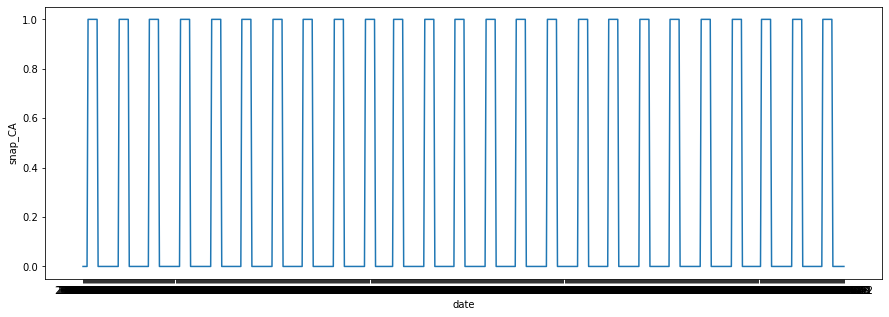

In [88]:
plt.figure(figsize=(15,5))
sns.lineplot(x='date', y='snap_CA', data=group)

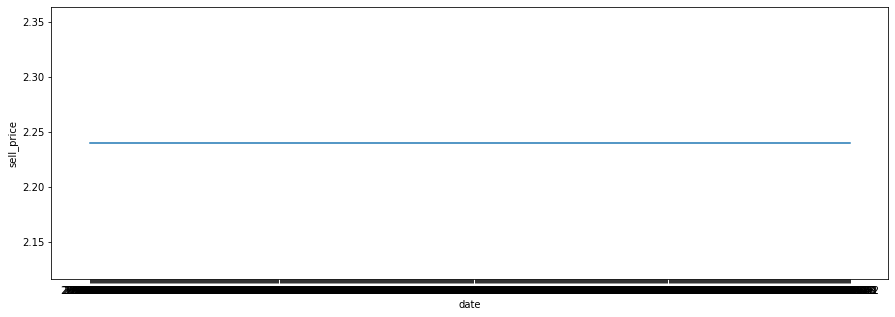

In [89]:
plt.figure(figsize=(15,5))
sns.lineplot(x='date', y='sell_price', data=group)

In [90]:
%%time
df_fe = simple_fe(df_data)

CPU times: user 6min 15s, sys: 1min, total: 7min 15s
Wall time: 7min 35s


In [97]:
for condition2, group2 in df_fe.groupby(by=['id']):
    break

In [168]:
group2[['demand', 'date']][:100]

,demand,date
1496,0.0,2014-04-26
29189,0.0,2014-04-27
56895,1.0,2014-04-28
84606,1.0,2014-04-29
112332,1.0,2014-04-30
140069,1.0,2014-05-01
167818,3.0,2014-05-02
195578,1.0,2014-05-03
223353,1.0,2014-05-04
251147,0.0,2014-05-05


In [91]:
weight_mat_csr = get_weight_mat_csr()
weight1, weight2 = weight_calc(df_fe, product)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
cv = TimeSeriesSplit()
for train_index, test_index in cv.split(df_fe):
    print()
    

In [34]:
# features = df_fe.columns.drop(['demand', 'id', 'part', 'date'])
# define random hyperparammeters for LGBM
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # demand features.
    "shift_t28",
    "shift_t29",
    "shift_t30",
    "rolling_mean_t7",
    "rolling_mean_t30",
    "rolling_mean_t60",
    "rolling_mean_t90",
    "rolling_mean_t180",
    # price features
    "price_change_t1",
    "price_change_t365",
    "rolling_price_std_t7",
    "rolling_price_std_t30",
    # time features.
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_year_end",
    "is_year_start",
    "is_quarter_end",
    "is_quarter_start",
    "is_month_end",
    "is_month_start",
    "is_weekend",
]

# going to evaluate with the last 28 days
x_train = df_fe[df_fe['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = df_fe[(df_fe['date'] > '2016-03-27') & (df_fe['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = df_fe[(df_fe['date'] > '2016-04-24')]

train_set = lgb.Dataset(x_train[features], y_train)
val_set = lgb.Dataset(x_val[features], y_val)

params = {
    'boosting_type': 'gbdt',
    'metric': 'custom',
    'objective': 'poisson',
    'n_jobs': -1,
    'seed': 236,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10, 
    'colsample_bytree': 0.75,
#     'num_leaves':31
}

# model estimation
model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50,  valid_sets = [train_set, val_set], verbose_eval = 100, feval= wrmsse)

predictions = test[['id', 'date', 'demand']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])
final.to_csv('submission.csv', index = False)

Training until validation scores don't improve for 50 rounds
[100]	training's wrmsse: 0.686194	valid_1's wrmsse: 0.624736
[200]	training's wrmsse: 0.63189	valid_1's wrmsse: 0.559668
[300]	training's wrmsse: 0.619437	valid_1's wrmsse: 0.546896
[400]	training's wrmsse: 0.603581	valid_1's wrmsse: 0.540315
[500]	training's wrmsse: 0.59684	valid_1's wrmsse: 0.53611
[600]	training's wrmsse: 0.589411	valid_1's wrmsse: 0.53128
Early stopping, best iteration is:
[637]	training's wrmsse: 0.58754	valid_1's wrmsse: 0.529628


<Figure size 360x720 with 0 Axes>

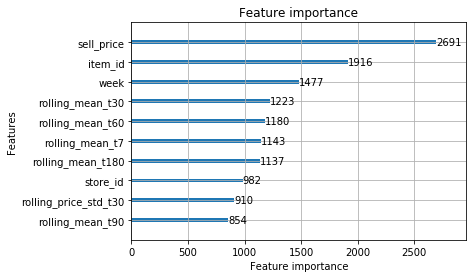

In [35]:
fig = plt.figure(figsize=(5,10))
lgb.plot_importance(model, max_num_features=10)

In [53]:
for cond, group in df_data.groupby(by=['id']):
    break

In [54]:
group.describe()

,item_id,dept_id,cat_id,store_id,state_id,demand,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,shift_t28,shift_t29,shift_t30,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30,rolling_std_t60,rolling_std_t90,rolling_std_t180,shift_price_t1,price_change_t1,rolling_price_max_t365,price_change_t365,rolling_price_std_t7,rolling_price_std_t30,year,quarter,month,week,day,dayofweek,is_year_end,is_year_start,is_quarter_end,is_quarter_start,is_month_end,is_month_start,is_weekend
count,758.0,758.0,758.0,758.0,758.0,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,7.580000e+02,730.000000,729.000000,728.000000,724.000000,701.000000,671.000000,641.000000,551.000000,724.000000,701.000000,671.000000,641.000000,551.000000,7.570000e+02,757.0,3.930000e+02,393.0,752.0,729.0,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000
mean,0.0,0.0,0.0,0.0,0.0,0.689974,11504.131926,28.746702,3.781003,3.997361,1.997361,0.329815,0.329815,0.329815,2.240000e+00,0.716438,0.717421,0.717033,0.718035,0.705516,0.693194,0.688664,0.679159,0.952392,1.030945,1.039390,1.043685,1.054665,2.240000e+00,0.0,2.240000e+00,0.0,0.0,0.0,2014.858839,2.489446,6.459103,26.511873,15.696570,3.006596,0.002639,0.002639,0.010554,0.010554,0.032982,0.032982,0.287599
std,0.0,0.0,0.0,0.0,0.0,1.042140,62.805174,4.903207,0.787658,0.072643,0.072643,0.470456,0.470456,0.470456,4.443824e-16,1.052988,1.053375,1.054048,0.397316,0.193090,0.120316,0.102033,0.081259,0.457233,0.205306,0.127159,0.103921,0.070761,4.443828e-16,0.0,4.446553e-16,0.0,0.0,0.0,0.706542,1.102067,3.405302,14.997727,8.805862,2.002959,0.051333,0.051333,0.102257,0.102257,0.178706,0.178706,0.452942
min,0.0,0.0,0.0,0.0,0.0,0.000000,11413.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.240000e+00,0.000000,0.000000,0.000000,0.000000,0.333333,0.416667,0.466667,0.533333,0.000000,0.546672,0.743142,0.820767,0.892951,2.240000e+00,0.0,2.240000e+00,0.0,0.0,0.0,2014.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.000000,11440.000000,30.000000,4.000000,4.000000,2.000000,0.000000,0.000000,0.000000,2.240000e+00,0.000000,0.000000,0.000000,0.428571,0.533333,0.600000,0.600000,0.605556,0.690066,0.884736,0.944057,0.977972,1.007406,2.240000e+00,0.0,2.240000e+00,0.0,0.0,0.0,2014.000000,2.000000,4.000000,14.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,0.0,0.0,0.0,0.000000,11515.000000,30.000000,4.000000,4.000000,2.000000,0.000000,0.000000,0.000000,2.240000e+00,0.000000,0.000000,0.000000,0.714286,0.700000,0.683333,0.688889,0.688889,0.816497,1.006302,1.048405,1.021675,1.040386,2.240000e+00,0.0,2.240000e+00,0.0,0.0,0.0,2015.000000,2.000000,6.000000,26.000000,16.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,0.0,0.0,1.000000,11542.000000,30.000000,4.000000,4.000000,2.000000,1.000000,1.000000,1.000000,2.240000e+00,1.000000,1.000000,1.000000,1.000000,0.833333,0.800000,0.777778,0.750000,1.214986,1.176885,1.121314,1.112240,1.123531,2.240000e+00,0.0,2.240000e+00,0.0,0.0,0.0,2015.000000,3.000000,9.000000,39.000000,23.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.0,0.0,0.0,0.0,0.0,7.000000,11617.000000,30.000000,4.000000,4.000000,2.000000,1.000000,1.000000,1.000000,2.240000e+00,7.000000,7.000000,7.000000,1.857143,1.266667,0.950000,0.933333,0.833333,2.563480,1.555487,1.335627,1.344522,1.190629,2.240000e+00,0.0,2.240000e+00,0.0,0.0,0.0,2016.000000,4.000000,12.000000,53.000000,31.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
df_data.shape[0]/30490/365

2.028717971758088

In [38]:
x_train.id.unique().shape

(30490,)

In [42]:
df_fe.shape[0]/30490/365

2.028717971758088

In [ ]:
def process(x_train, y_train, x_val, y_val, test, features):
    
    train_set = lgb.Dataset(x_train[features], y_train)
    val_set = lgb.Dataset(x_val[features], y_val)
    params = {
    'boosting_type': 'gbdt',
    'metric': 'custom',
    'objective': 'poisson',
    'n_jobs': -1,
    'seed': 236,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10, 
    'colsample_bytree': 0.75}
    # model estimation
    model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50,  valid_sets = [train_set, val_set], verbose_eval = 100, feval= wrmsse)
    y_pred = model.predict(test[features])
    return y_pred